In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../data"))
# print(os.listdir("../input/glove-global-vectors-for-word-representation"))
# print(os.listdir("../input/jigsaw-unintended-bias-in-toxicity-classification"))

# Any results you write to the current directory are saved as output.

['all_data.csv', 'crawl-300d-2M.vec', 'glove.6B.100d.txt', 'glove.840B.300d.txt', 'identity_individual_annotations.csv', 'sample_submission.csv', 'test.csv', 'test_private_expanded.csv', 'test_public_expanded.csv', 'toxicity_individual_annotations.csv', 'train.csv']


In [24]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import datetime
import os
import pandas as pd
import numpy as np
import pkg_resources
import seaborn as sns
import time
import scipy.stats as stats

from sklearn import metrics
from sklearn import model_selection

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from keras.models import Model
from keras.models import load_model

## Load and pre-process the data set

In [25]:
#train = pd.read_csv('../data/train.csv', nrows=1000)
train = pd.read_csv('../data/train.csv')
print('loaded %d records' % len(train))

# Make sure all comment_text values are strings
train['comment_text'] = train['comment_text'].astype(str) 

# List all identities
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['target'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

train = convert_dataframe_to_bool(train)

loaded 1804874 records


In [26]:
identity_columns_all = [
    'asian', 'atheist', 'bisexual',
    'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
    'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
    'jewish', 'latino', 'male', 'muslim', 'other_disability',
    'other_gender', 'other_race_or_ethnicity', 'other_religion',
    'other_sexual_orientation', 'physical_disability',
    'psychiatric_or_mental_illness', 'transgender', 'white'
]

### Subset training data for ease of computation

In [27]:
train = train.sample(frac=0.1, random_state=0)

In [33]:
## Target base rate
train.target.mean()

0.08088117149711614

In [42]:
train[train.target==1].comment_text.iloc[8]

'I think it conservative idiots who cannot react in proportion.'

In [54]:
train[train.target==1].comment_text.iloc[19]

"So, it's every person for his or her miserable selfish self, huh Kyle?"

## Split the data into 80% train and 20% validate sets

In [28]:
train_df, validate_df = model_selection.train_test_split(train, test_size=0.2, random_state=0)
print('%d train comments, %d validate comments' % (len(train_df), len(validate_df)))


144389 train comments, 36098 validate comments


## Create a text tokenizer

In [ ]:
MAX_NUM_WORDS = 10000
TOXICITY_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'

# Create a text tokenizer.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_df[TEXT_COLUMN])

# All comments must be truncated or padded to be the same length.
MAX_SEQUENCE_LENGTH = 250
def pad_text(texts, tokenizer):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)

## Define and train a Convolutional Neural Net for classifying toxic comments

In [ ]:
EMBEDDINGS_PATH = '../data/glove.6B.100d.txt'
EMBEDDINGS_DIMENSION = 100
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.00005
NUM_EPOCHS = 10
BATCH_SIZE = 128

def train_model(train_df, validate_df, tokenizer):
    # Prepare data
    train_text = pad_text(train_df[TEXT_COLUMN], tokenizer)
    train_labels = to_categorical(train_df[TOXICITY_COLUMN])
    validate_text = pad_text(validate_df[TEXT_COLUMN], tokenizer)
    validate_labels = to_categorical(validate_df[TOXICITY_COLUMN])

    # Load embeddings
    print('loading embeddings')
    embeddings_index = {}
    with open(EMBEDDINGS_PATH, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1,
                                 EMBEDDINGS_DIMENSION))
    num_words_in_embedding = 0
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            num_words_in_embedding += 1
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # Create model layers.
    def get_convolutional_neural_net_layers():
        """Returns (input_layer, output_layer)"""
        sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
        embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                                    EMBEDDINGS_DIMENSION,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
        x = embedding_layer(sequence_input)
        x = Conv1D(128, 2, activation='relu', padding='same')(x)
        x = MaxPooling1D(5, padding='same')(x)
        x = Conv1D(128, 3, activation='relu', padding='same')(x)
        x = MaxPooling1D(5, padding='same')(x)
        x = Conv1D(128, 4, activation='relu', padding='same')(x)
        x = MaxPooling1D(40, padding='same')(x)
        x = Flatten()(x)
        x = Dropout(DROPOUT_RATE)(x)
        x = Dense(128, activation='relu')(x)
        preds = Dense(2, activation='softmax')(x)
        return sequence_input, preds

    # Compile model.
    print('compiling model')
    input_layer, output_layer = get_convolutional_neural_net_layers()
    model = Model(input_layer, output_layer)
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(lr=LEARNING_RATE),
                  metrics=['acc'])

    # Train model.
    print('training model')
    model.fit(train_text,
              train_labels,
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(validate_text, validate_labels),
              verbose=2)

    return model

model = train_model(train_df, validate_df, tokenizer)

## Generate model predictions on the validation set

In [ ]:
MODEL_NAME = 'my_model'
validate_df[MODEL_NAME] = model.predict(pad_text(validate_df[TEXT_COLUMN], tokenizer))[:, 1]

In [ ]:
validate_df.head()

## Define bias metrics, then evaluate our new model for bias using the validation set predictions

In [ ]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

bias_metrics_df = compute_bias_metrics_for_model(validate_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df


In [ ]:
bias_metrics_df = compute_bias_metrics_for_model(validate_df, identity_columns_all, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

## Calculate the final score

In [ ]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
    
get_final_metric(bias_metrics_df, calculate_overall_auc(validate_df, MODEL_NAME))

## Prediction on Test data

In [ ]:
test = pd.read_csv('../data/test.csv')
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')

In [ ]:
test.shape

In [ ]:
#submission['prediction'] = model.predict(pad_text(test[TEXT_COLUMN], tokenizer))[:, 1]
# submission.to_csv('submission.csv')

---

### Input data

#### Raw data

In [29]:
train_desc = train.dtypes.to_frame(name="type")
train_desc["missing_prop"] = [train[col].isnull().sum() / train.shape[0] for col in train_desc.index]

## Distribution of numeric columns
train_desc_numeric = train_desc[
    (train_desc.type=="int64") | (train_desc.type=="float64")
].copy()
train_desc_numeric["mean"] = [train[col].mean() for col in train_desc_numeric.index]
train_desc_numeric["median"] = [train[col].median() for col in train_desc_numeric.index]
train_desc_numeric["std"] = [train[col].std() for col in train_desc_numeric.index]
train_desc_numeric["min"] = [train[col].min() for col in train_desc_numeric.index]
train_desc_numeric["max"] = [train[col].max() for col in train_desc_numeric.index]
train_desc_numeric.drop(columns=["type", "missing_prop"], inplace=True)

## Find proportion of true values for booleans
train_desc_bool = train_desc[(train_desc.type=="bool")].copy()
train_desc_bool["mean"] = [train[col].mean() for col in train_desc_bool.index]
train_desc_bool.drop(columns=["type", "missing_prop"], inplace=True)

## Combine stats
train_desc_nonstr = pd.concat([train_desc_numeric, train_desc_bool])
train_desc = pd.concat([train_desc, train_desc_nonstr], axis=1)

## Get rid of id features and target
train_desc = train_desc[~train_desc.index.str.endswith("id")]
train_desc.drop(index="target", inplace=True)

In [32]:
train_desc

,type,missing_prop,mean,median,std,min,max
comment_text,object,0.000000,NaN,NaN,NaN,NaN,NaN
severe_toxicity,float64,0.000000,0.004656,0.0,0.022997,0.0,0.600000
obscene,float64,0.000000,0.014258,0.0,0.066188,0.0,1.000000
identity_attack,float64,0.000000,0.022551,0.0,0.078741,0.0,1.000000
insult,float64,0.000000,0.081502,0.0,0.176302,0.0,1.000000
threat,float64,0.000000,0.009279,0.0,0.049485,0.0,1.000000
asian,float64,0.775989,0.011933,0.0,0.086801,0.0,1.000000
atheist,float64,0.775989,0.003121,0.0,0.049543,0.0,1.000000
bisexual,float64,0.775989,0.001926,0.0,0.027667,0.0,1.000000
black,bool,0.000000,0.008549,NaN,NaN,NaN,NaN


In [32]:
train_desc.to_csv("../output/train_description_0.1.csv")

## Comment examples by feature identifier

In [55]:
## Large annotator consensus
train[train.atheist==1].comment_text.iloc[2]

'I am an atheist, but I will defend Imago Dei as NOT being one of those evangelical churches that gets involved in right-wing politics or campaigning. They are involved with the social needs of the community, including the poor and needy. (Their discreet homophobia and misogyny notwithstanding.)'

In [100]:
## Medium annotator consensus
train[(train.atheist>0.4) & (train.atheist<0.6)].comment_text.iloc[0]

'Genesis 2:7, Matthew 16:25-26, John 15:13, Acts 2:41, Mt 10:28; 26:38; John 12:27, 2 Maccabees 6:30, 1 Corinthians 6:19-20; 15:44-45, and so on. Jesus promises eternal life for those who love Him and keep his commandments.\n\nObviously these are evidence for believing Christians and may inapplicable to atheists, agnostics, and other skeptics.'

In [98]:
## Low annotator consensus
train[(train.atheist>0) & (train.atheist<0.4)].comment_text.iloc[14]

'Orange really is the new black!'

In [108]:
## Christian comment
train[train.christian].comment_text.iloc[5]

'Good for them!  Thank you for being there, ladies.  Pence is a conservative Christian prig who likes nothing better than “keeping them barefoot and pregnant in the kitchen.”  Save us should the likes of him become President.....'

In [13]:
train[train.christian].iloc[5]

id                                                                               6233424
target                                                                             False
comment_text                           Good for them!  Thank you for being there, lad...
severe_toxicity                                                                      0.0
obscene                                                                              0.0
identity_attack                                                                      0.2
insult                                                                               0.2
threat                                                                               0.0
asian                                                                                0.0
atheist                                                                              0.0
bisexual                                                                             0.0
black                

In [11]:
## Not a Christian comment
train[~train.christian].comment_text.iloc[4]

"The elites, both Democrat and Republican, both tried to grease Trumps's wheels."

In [14]:
train[~train.christian].iloc[4]

id                                                                               6220033
target                                                                             False
comment_text                           The elites, both Democrat and Republican, both...
severe_toxicity                                                                      0.0
obscene                                                                              0.0
identity_attack                                                                      0.0
insult                                                                               0.0
threat                                                                               0.0
asian                                                                                0.0
atheist                                                                              0.0
bisexual                                                                             0.0
black                

---

#### Pairwise correlations

<AxesSubplot:>

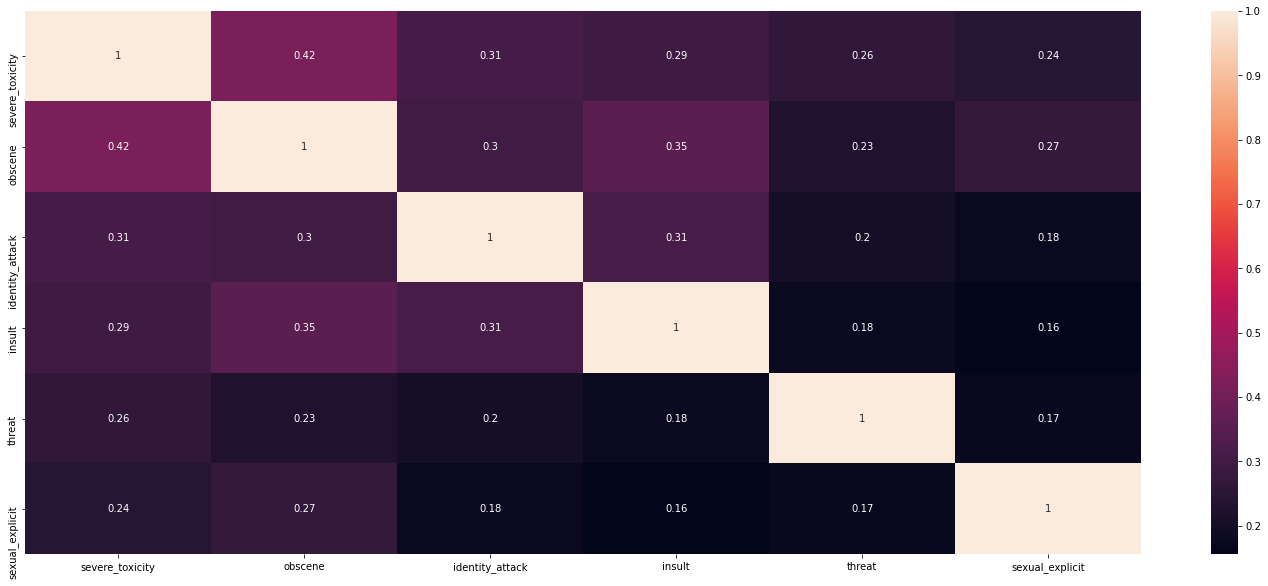

In [38]:
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt

cols = ['severe_toxicity',
         'obscene',
         'identity_attack',
         'insult',
         'threat',
         'sexual_explicit']

train = train[cols]
train = train.dropna()

dataset = train
mi_df = pd.DataFrame(columns=cols, index=cols, dtype=float)
for row in mi_df.columns:
    for col in mi_df.columns:
        mi_df.loc[row, col] = normalized_mutual_info_score(dataset[row].astype(str),
                                                           dataset[col].astype(str),
                                                           average_method='arithmetic')

plt.figure(figsize=(25,10))
sns.heatmap(mi_df, annot=True)

---

#### Text data

In [21]:
train_text = pad_text(train[TEXT_COLUMN], tokenizer)
train_labels = to_categorical(train[TOXICITY_COLUMN])

In [29]:
train[TEXT_COLUMN].iloc[0:2]

546354    The 1080 hours of student learning time is jus...
412488    I think the author is absolutely correct when ...
Name: comment_text, dtype: object

---

### Output

In [17]:
## temp
preds = model.predict(pad_text(test[TEXT_COLUMN], tokenizer))[:, 1]
preds

array([9.02433041e-03, 1.18368752e-01, 1.22536443e-01, 1.25115328e-02,
       3.18642543e-03, 2.23132200e-03, 8.24825406e-01, 3.02035093e-01,
       1.29422508e-02, 1.88045595e-02, 4.59464937e-02, 2.94275973e-02,
       3.24388780e-03, 6.24678060e-02, 9.35081393e-03, 2.22676788e-02,
       3.52768987e-01, 4.95862542e-03, 1.33742252e-02, 3.36573929e-01,
       2.14248281e-02, 1.97450042e-01, 1.30859006e-03, 1.08422227e-02,
       1.98889431e-02, 9.30002984e-03, 1.61680683e-01, 2.30977070e-02,
       9.19810776e-03, 6.07676804e-03, 1.72217749e-02, 2.61967117e-03,
       1.06260246e-02, 8.58451650e-02, 7.82493725e-02, 7.91529834e-01,
       4.36441571e-01, 1.65753681e-02, 6.83006225e-03, 1.93178561e-03,
       4.57414193e-03, 1.43695682e-01, 5.57522348e-04, 8.07188749e-02,
       1.36943650e-03, 2.02197805e-02, 2.64718253e-02, 8.42280462e-02,
       1.10387942e-02, 7.27165351e-03, 2.00898219e-02, 5.65552235e-01,
       1.87488161e-02, 2.97811185e-03, 2.66430434e-02, 1.81792043e-02,
      

The model outputs probabilities that a given comment is toxic

---